In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,Model, Input, Sequential
import tensorflow_probability as tfp

import gym
import numpy as np
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [ ]:
env = gym.make("CartPole-v0")
lr = 0.0001

# PyTorch Example in Tensorflow (Learning, but slowly)

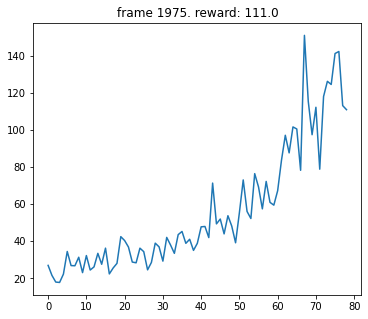

In [ ]:
class ActorCritic(tf.keras.Model):
    def __init__(self, n_inputs, n_outputs):
        super(ActorCritic, self).__init__()
        self.actor_layers = [layers.Dense(128, input_shape =(n_inputs,), activation = tf.nn.relu), 
                             layers.Dense(n_outputs, activation = tf.nn.softmax)]
        self.critic_layers = [layers.Dense(128, input_shape =(n_inputs,), activation = tf.nn.relu), 
                              layers.Dense(1, activation = tf.nn.tanh)]
        self.actor = Sequential(self.actor_layers)

        self.critic = Sequential(self.critic_layers)
    
    def call(self, inputs):
        probs = self.actor(inputs)
        dist = tfp.distributions.Categorical(probs = probs)
        value = self.critic(inputs)
        return dist, value

model = ActorCritic(n_inputs= 4, n_outputs= 2)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def test(n_episodes = 10):
    scores = []
    for episode in range(n_episodes):
        state = env.reset()
        done = False
        score = 0
        while not done:
            state = np.expand_dims(state, axis = 0)
            dist, value = model(state)
            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy()[0])
            score += reward
            state = next_state
        scores.append(score)
    avg_score = sum(scores)/len(scores)
    return avg_score


def train(n_episodes = 100, max_iter = 1000, gamma = 1.0, update_every = 25):
    avg_scores = []
    for episode in range(n_episodes):
        state = env.reset()
        rewards = []
        log_probs = []
        values = []
        tape = tf.GradientTape()
        tape.__enter__()
        for _ in range(max_iter):
            dist, value = model(np.expand_dims(state, axis = 0))
            action = dist.sample()
            log_prob = dist.log_prob(action)
            next_state, reward, done, _ = env.step(action.numpy()[0])
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            state = next_state
            if done:break

        returns = []
        R = 0
        for r in rewards[::-1]:
            R = r + gamma*R
            returns.insert(0,R)
        
        log_probs = tf.squeeze(tf.convert_to_tensor(log_probs))
        values = tf.squeeze(tf.convert_to_tensor(values))
        returns = tf.convert_to_tensor(returns)
        returns = tf.stop_gradient(returns - tf.math.reduce_mean(returns))

        advantages = tf.stop_gradient(returns - values)
        policy_losses = - log_probs * advantages
        value_losses = (returns - values)**2
        
        policy_losses = tf.convert_to_tensor(policy_losses)
        value_losses = tf.convert_to_tensor(value_losses)
        loss = tf.math.reduce_sum(policy_losses) + tf.math.reduce_sum(value_losses)
        tape.__exit__(None, None, None)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
   
        
        if episode % update_every == 0 and episode > 0:
            avg_score = test()
            avg_scores.append(avg_score)
            plot(episode, avg_scores )
            
train(2000)

# One network with Two heads

In [ ]:
inputs = Input(shape=(4,))
x = layers.Dense(128, activation = tf.nn.relu)(inputs)
policy_head = layers.Dense(2, activation = tf.nn.softmax)(x)
value_head = layers.Dense(1)(x)
model = Model(inputs = inputs, outputs = [policy_head, value_head])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def predict(obs):
    obs = tf.expand_dims(tf.convert_to_tensor(obs), axis = 0)
    probs, value = model(obs)
    m = tfp.distributions.Categorical(probs=probs)
    action = m.sample()
    return action.numpy()[0], m.log_prob(action), value

def train(n_episodes = 100, max_iter = 1000, gamma = 1.0, update_every = 25):
    scores_window = deque(maxlen = update_every)
    for episode in range(n_episodes):
        obs = env.reset()
        score = 0
        for _ in range(max_iter):
            with tf.GradientTape(persistent=True) as tape:
                action, log_prob, pred_value = predict(obs)
                new_obs, reward, done, _ = env.step(action)
                _,_, next_value = predict(new_obs)
                target = reward + gamma*next_value
                # value_loss = tf.keras.losses.mean_squared_error(target, pred_value)
                value_loss = (target - pred_value)**2
                policy_loss = -log_prob * (target-pred_value)
                loss = value_loss + policy_loss

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            obs = new_obs
            score += reward
            if done:break

        scores_window.append(score)
        
        if episode % update_every == 0 and episode > 0:
            print("episode {}   AverageScore {}".format(episode, np.mean(scores_window)))        

train(2000)

# Seperate Value and Policy networks

In [ ]:
inputs = Input(shape=(4,))
x = layers.Dense(128, activation = tf.nn.relu)(inputs)
outputs = layers.Dense(2, activation = tf.nn.softmax)(x)
policy_est = Model(inputs = inputs, outputs = outputs)

inputs = Input(shape=(4,))
x = layers.Dense(128, activation = tf.nn.relu)(inputs)
outputs = layers.Dense(1)(x)
value_est = Model(inputs = inputs, outputs = outputs)

policy_opt = tf.keras.optimizers.Adam(learning_rate=lr)
value_opt = tf.keras.optimizers.Adam(learning_rate=lr)

def predict_action(obs):
    obs = tf.expand_dims(tf.convert_to_tensor(obs), axis = 0)
    probs = policy_est(obs)
    m = tfp.distributions.Categorical(probs=probs)
    action = m.sample()
    return action.numpy()[0],m.log_prob(action)

def predict_value(obs):
    obs = tf.expand_dims(tf.convert_to_tensor(obs), axis = 0)
    value = value_est(obs)
    return value

def train(n_episodes = 100, max_iter = 1000, gamma = 1.0, update_every = 25):
    scores_window = deque(maxlen = update_every)
    for episode in range(n_episodes):
        obs = env.reset()
        score = 0
        for _ in range(max_iter):
            with tf.GradientTape(persistent=True) as tape:
                action, log_prob = predict_action(obs)
                new_obs, reward, done, _ = env.step(action)
                pred_value = predict_value(obs)
                target = reward + gamma*predict_value(new_obs)
                value_loss = tf.keras.losses.mean_squared_error(target, pred_value)
                policy_loss = -log_prob * (target-pred_value)

            grads = tape.gradient(value_loss, value_est.trainable_variables)
            value_opt.apply_gradients(zip(grads,value_est.trainable_variables))
            grads_ = tape.gradient(policy_loss, policy_est.trainable_variables)
            policy_opt.apply_gradients(zip(grads_, policy_est.trainable_variables))
            obs = new_obs
            score += reward
            if done:break
        scores_window.append(score)
        
        if episode % update_every == 0 and episode > 0:
            print("episode {}   AverageScore {}".format(episode, np.mean(scores_window)))        

train(500)


In [ ]:
r = tf.convert_to_tensor([1.0,2.0,3.0,4.0,5.0])
v = tf.convert_to_tensor([10.0,20.0,30.0,40.0,50.0])

adv = tf.stop_gradient(r-v)


with tf.GradientTape(persistent=True) as tape:

    tape.watch(v)
    pl = tf.math.log(v) * adv
    vl = (r-v)**2
grads = tape.gradient(vl,v)

print(grads)


tf.Tensor([18. 36. 54. 72. 90.], shape=(5,), dtype=float32)
